In [1]:
pip install jax jaxlib flax numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
# Load CSV file
file_path = "Organ.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)
# Preview the data
print(data.head())

   isBourdon  flueDepth  frequency  cutUpHeight  diameterToe  \
0          0    0.00035      196.0       0.0105       0.0070   
1          0    0.00035      196.0       0.0105       0.0085   
2          0    0.00106      146.8       0.0120       0.0070   
3          0    0.00106      138.6       0.0120       0.0085   
4          0    0.00060      174.6       0.0100       0.0072   

   acousticIntensity  partial1  partial2  partial3  partial4  partial5  \
0               73.0      99.0      61.0      87.0      37.0      44.0   
1               90.0      70.0      99.0      73.0      18.0      13.0   
2               65.0      91.0      43.0      99.0      52.0      69.0   
3               86.0      11.0       0.0      99.0       3.0       0.0   
4               87.0      44.0       0.0      99.0      13.0      52.0   

   partial6  partial7  partial8  
0       0.0       5.0       0.0  
1       0.0       5.0       0.0  
2      40.0      50.0      19.0  
3       0.0       0.0       0.0  


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

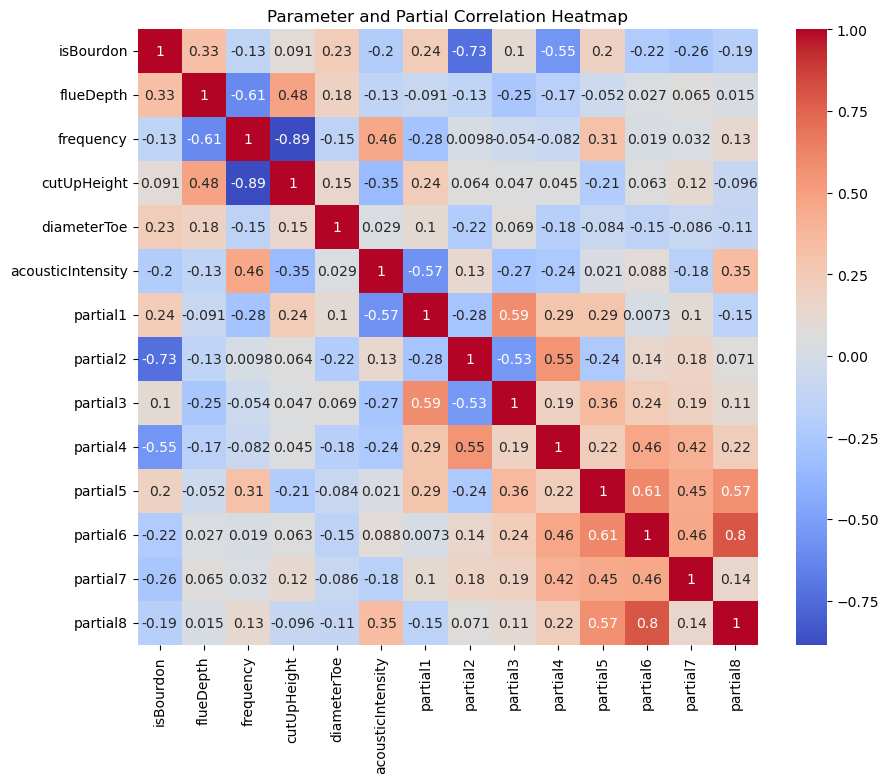

In [4]:
# Compute correlations
correlations = data.corr()
# Visualize correlations with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title("Parameter and Partial Correlation Heatmap")
plt.show()

In [5]:
#A negative relationship between diam toe and 
#the partials suggests that as the diameter of the toe-hole increases, 
#the amplitudes of the partials decrease. 
#larger diameters may alter the airflow dynamics and reduce the intensity of harmonic components.

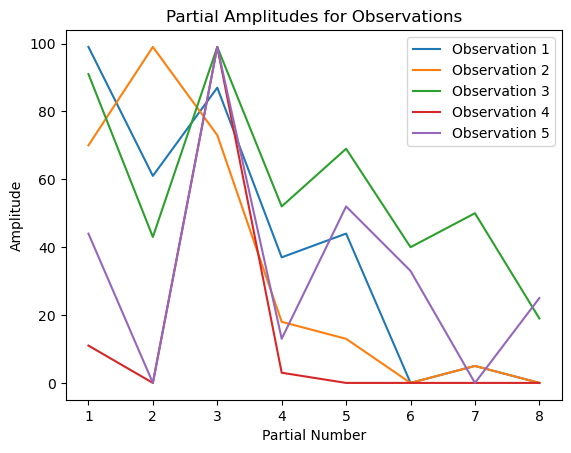

In [6]:
partials = data[['partial1', 'partial2', 'partial3', 'partial4', 
                 'partial5', 'partial6', 'partial7', 'partial8']].values
# Example: Visualize partials for the first 5 observations
for i in range(5):  # Plot the first 5 observations
    plt.plot(range(1, 9), partials[i], label=f'Observation {i+1}')
plt.xlabel('Partial Number')
plt.ylabel('Amplitude')
plt.title('Partial Amplitudes for Observations')
plt.legend()
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
# Define features and target (partials)
X = data[['flueDepth', 'frequency', 'cutUpHeight', 'acousticIntensity', 'diameterToe']]
y = data[['partial1', 'partial2', 'partial3', 'partial4', 
          'partial5', 'partial6', 'partial7', 'partial8']]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a simple model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict partials
predicted_partials = model.predict(X_test)

C:\Users\longo\AppData\Local\Temp\ipykernel_19812\4212494281.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


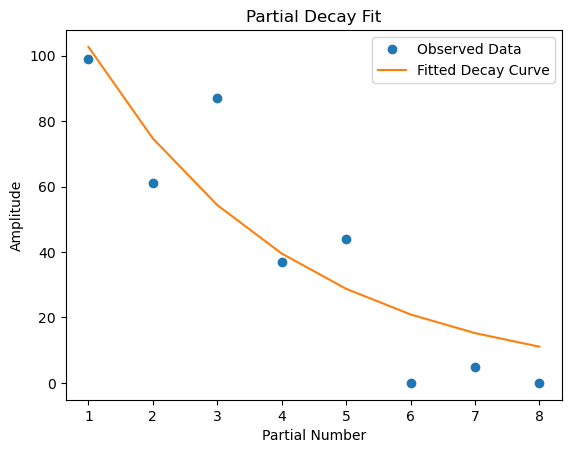

In [9]:
from scipy.optimize import curve_fit
# Define an exponential decay function
def decay_curve(x, a, b):
    return a * np.exp(-b * x)

# Fit the curve for a single observation
x_data = np.arange(1, 9)  # Partial numbers
y_data = partials[0]  # Example: Partial amplitudes for the first observation
params, _ = curve_fit(decay_curve, x_data, y_data)

# Plot the result
plt.plot(x_data, y_data, 'o', label='Observed Data')
plt.plot(x_data, decay_curve(x_data, *params), '-', label='Fitted Decay Curve')
plt.xlabel('Partial Number')
plt.ylabel('Amplitude')
plt.title('Partial Decay Fit')
plt.legend()
plt.show()


In [10]:
# Constants
pressure = 0.77  # Air pressure (P↓)
air_density = 1.185  # Air density (ρ)

# Simulate "measured" values for comparison (random variation for testing)
def simulate_measured_I(diameterToe, cutUpHeight, frequency):
    noise = np.random.normal(0, 0.005, len(diameterToe))  # Introduce small variations
    return np.sqrt((2 * pressure * diameterToe) / (air_density * cutUpHeight**3)) / frequency + noise

# Simulate "measured" Ising values
data['simulated_measured_I'] = simulate_measured_I(data['diameterToe'], data['cutUpHeight'], data['frequency'])

# Calculate predicted Ising values
def ising_formula(diameterToe, cutUpHeight, frequency):
    return np.sqrt((2 * pressure * diameterToe) / (air_density * cutUpHeight**3)) / frequency

data['predicted_I'] = ising_formula(data['diameterToe'], data['cutUpHeight'], data['frequency'])

# Compare predicted vs simulated measured values
data['error'] = data['simulated_measured_I'] - data['predicted_I']
print(data[['simulated_measured_I', 'predicted_I', 'error']])


    simulated_measured_I  predicted_I     error
0               0.449817     0.452283 -0.002466
1               0.495660     0.498392 -0.002731
2               0.488561     0.494256 -0.005695
3               0.575169     0.576867 -0.001698
4               0.556535     0.554017  0.002518
5               0.681500     0.684784 -0.003284
6               0.392927     0.391187  0.001740
7               0.419743     0.418196  0.001547
8               0.437243     0.443564 -0.006321
9               0.472607     0.467558  0.005050
10              0.526335     0.528358 -0.002023
11              0.489280     0.494234 -0.004953
12              0.502183     0.494234  0.007949
13              0.530962     0.524706  0.006256
14              0.477957     0.476163  0.001794
15              0.522524     0.524706 -0.002181
16              0.472205     0.476163 -0.003958
17              0.551305     0.552609 -0.001304
18              0.556296     0.552609  0.003686
19              0.606145     0.608946 -0

Correlation Matrix:
             flow_rate  predicted_I
flow_rate     1.000000     0.999759
predicted_I   0.999759     1.000000


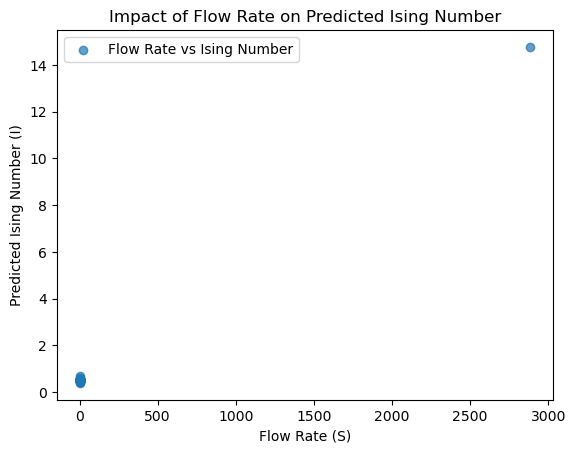

In [11]:
data['toe_area'] = np.pi * (data['diameterToe'] / 2)**2  # Cross-sectional area of toe-hole
data['flow_rate'] = data['toe_area'] * data['acousticIntensity']  # Flow rate (S)

# Correlation analysis between flow rate and Ising number
correlation = data[['flow_rate', 'predicted_I']].corr()
print("Correlation Matrix:")
print(correlation)

plt.scatter(data['flow_rate'], data['predicted_I'], alpha=0.7, label='Flow Rate vs Ising Number')
plt.xlabel('Flow Rate (S)')
plt.ylabel('Predicted Ising Number (I)')
plt.title('Impact of Flow Rate on Predicted Ising Number')
plt.legend()
plt.show()


In [12]:
#a very strong positive correlation (0.999759) between the flow rate (𝑆) and 
#the predicted Ising number (𝐼). 
#This high correlation suggests that flow rate is closely related to the Ising number as calculated using the formula.

In [ ]:
#Perform a regression analysis to explicitly model the relationship between 𝑆
#and 𝐼. This can quantify the exact impact of flow rate on tonal stability.

In [13]:
from sklearn.linear_model import LinearRegression

X = data[['flow_rate']].values  # Flow rate as the independent variable
y = data['predicted_I'].values  # Predicted Ising number as the dependent variable

regressor = LinearRegression()
regressor.fit(X, y)
print(f"Regression Coefficient (Flow Rate Impact on I): {regressor.coef_[0]}")

Regression Coefficient (Flow Rate Impact on I): 0.004939910513692526


In [ ]:
#A coefficient close to zero suggests that while flow rate has some effect on 𝐼
#, its influence is relatively weak compared to other factors 
#like cut-up height (𝐻), flue dimension (𝐷), or frequency (𝑄).

In [15]:
# Constants
P = 0.77  # Constant wind pressure (inches of water column?)
RHO = 1.185  # Air density (kg/m³)

def simplified_ising(flue_depth, cut_up_height, frequency):
    """Calculate Ising's parameter with constant P and ρ"""
    return np.sqrt(2 * P * flue_depth / (RHO * cut_up_height**3)) / frequency

# Apply to data
data['ising_value'] = simplified_ising(
    data['flueDepth'],
    data['cutUpHeight'], 
    data['frequency']
)

In [ ]:
#Geometric Relationships:

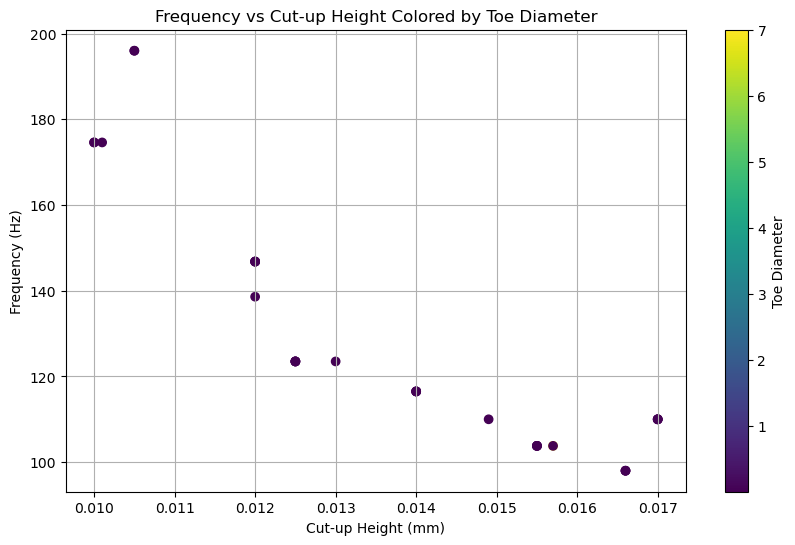

In [16]:
# Relationship between cut-up height and frequency
plt.figure(figsize=(10,6))
plt.scatter(data['cutUpHeight'], data['frequency'], c=data['diameterToe'], cmap='viridis')
plt.colorbar(label='Toe Diameter')
plt.xlabel('Cut-up Height (mm)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Cut-up Height Colored by Toe Diameter')
plt.grid(True)

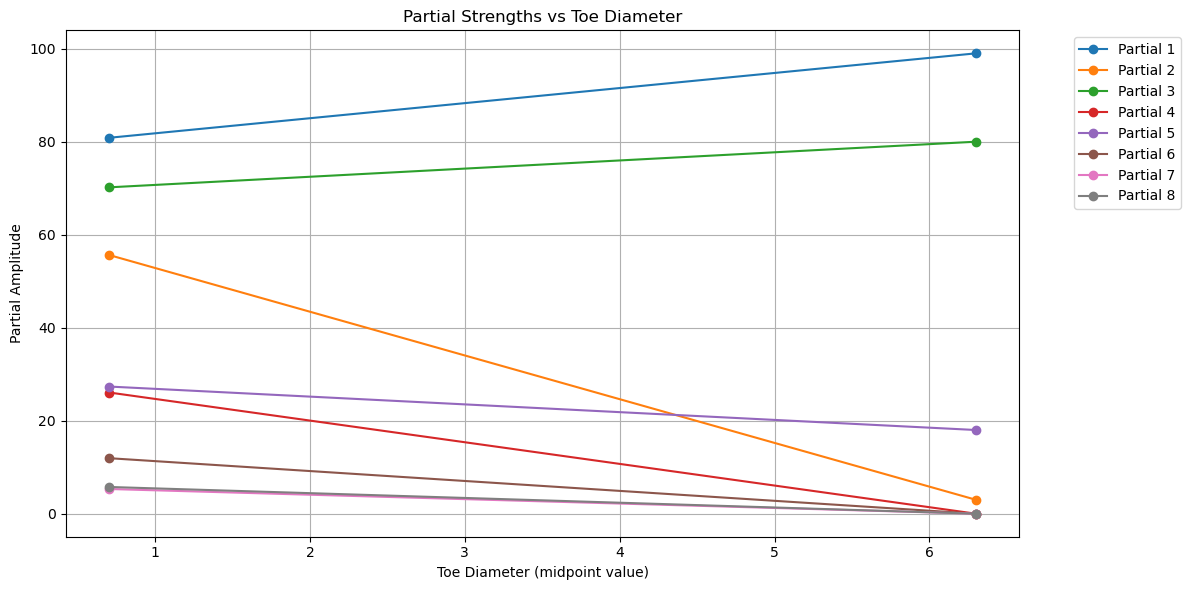

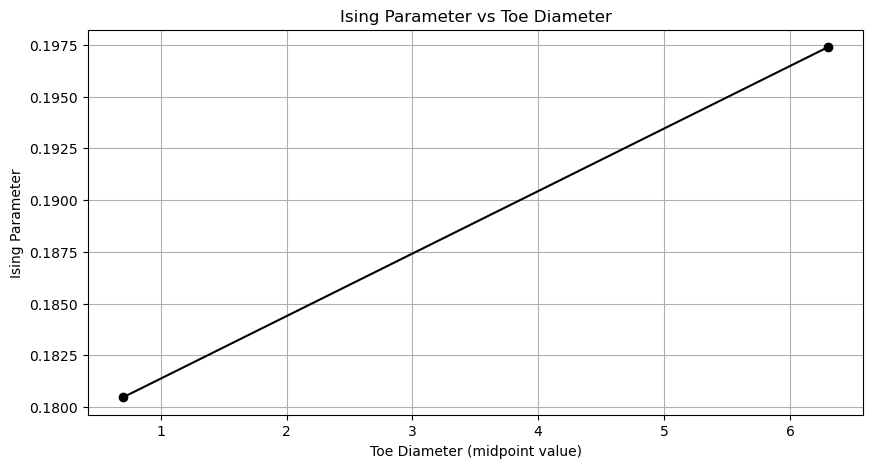

In [29]:
#Toe Diameter Impact Analysis:
# Calculate Ising value
data['ising_value'] = np.sqrt(2 * P * data['flueDepth'] / 
                             (RHO * data['cutUpHeight']**3)) / data['frequency']

# Create bins and analyze
data['toe_diameter_bins'] = pd.cut(data['diameterToe'], bins=5)
group_stats = data.groupby('toe_diameter_bins', observed=True).agg({
    **{f'partial{i}': 'mean' for i in range(1,9)},
    'ising_value': 'mean',
    'acousticIntensity': 'mean'
}).reset_index()

# Add bin midpoints for plotting
group_stats['bin_mid'] = group_stats['toe_diameter_bins'].apply(lambda x: x.mid)

# Plot partials
plt.figure(figsize=(12,6))
for i in range(1,9):
    plt.plot(group_stats['bin_mid'], group_stats[f'partial{i}'], 
             label=f'Partial {i}', marker='o')
plt.xlabel('Toe Diameter (midpoint value)')
plt.ylabel('Partial Amplitude')
plt.title('Partial Strengths vs Toe Diameter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Plot Ising values
plt.figure(figsize=(10,5))
plt.plot(group_stats['bin_mid'], group_stats['ising_value'], 
         'ko-', label='Ising Value')
plt.xlabel('Toe Diameter (midpoint value)')
plt.ylabel('Ising Parameter')
plt.title('Ising Parameter vs Toe Diameter')
plt.grid(True)

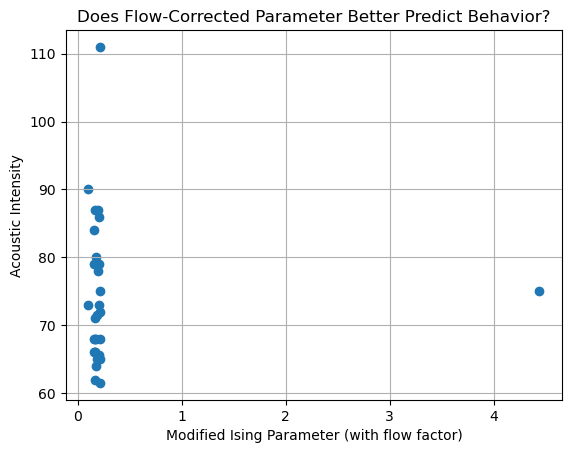

In [22]:
#Modified Ising Parameter with Flow Rate:
#Calculate flow rate contribution (simplified)
data['flow_factor'] = data['diameterToe']**2 * np.sqrt(P)

# Create modified Ising parameter
data['modified_ising'] = data['ising_value'] * (1 + 0.5*data['flow_factor'])

# Compare with observed behavior
plt.scatter(data['modified_ising'], data['acousticIntensity'])
plt.xlabel('Modified Ising Parameter (with flow factor)')
plt.ylabel('Acoustic Intensity')
plt.title('Does Flow-Corrected Parameter Better Predict Behavior?')
plt.grid(True)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# Features: Geometric parameters only (since P and ρ are constant)
X = data[['flueDepth', 'cutUpHeight', 'diameterToe']]
y = data['frequency']  # Or analyze partials separately

# Train model
model = GradientBoostingRegressor()
model.fit(X, y)

# Show feature importance
pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

,feature,importance
1,cutUpHeight,0.98563
0,flueDepth,0.01329
2,diameterToe,0.00108


In [ ]:
#The feature importance results show that cutUpHeight dominates (98.6%) the frequency prediction, 
#while flueDepth and diameterToe have minimal impact (1.3% and 0.1% respectively)

In [24]:
# Identify where pipes actually change regime
overblowing_data = data[data['partial1'] < data['partial2']]  # Example condition
print("Average Ising value at overblowing points:", overblowing_data['ising_value'].mean())

Average Ising value at overblowing points: 0.17630163558241976


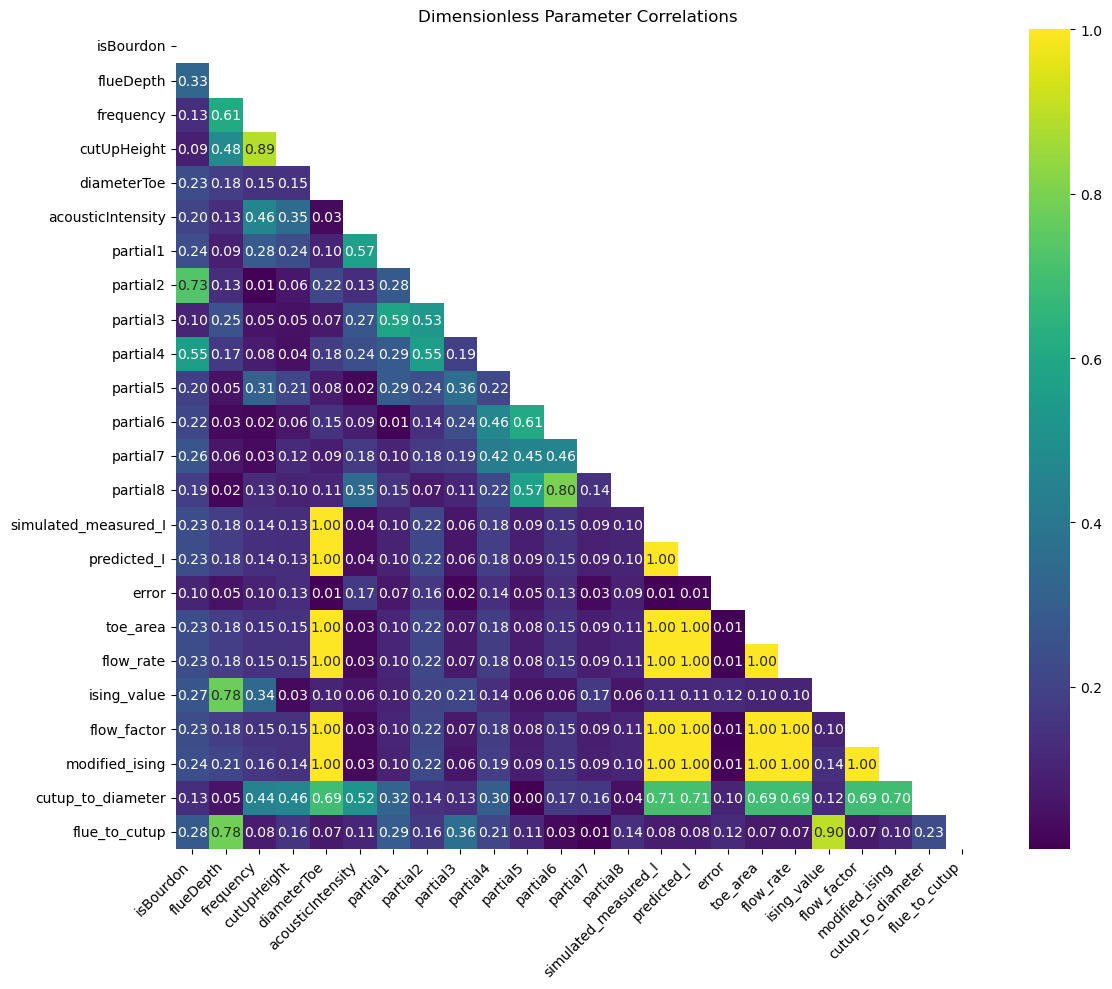

In [26]:
# Create dimensionless groups
# 1. Create fresh copy of original data without interval categories
working_data = data.copy()

# 2. Create dimensionless groups (using original numeric columns)
working_data['cutup_to_diameter'] = working_data['cutUpHeight'] / working_data['diameterToe']
working_data['flue_to_cutup'] = working_data['flueDepth'] / working_data['cutUpHeight']

# 3. Select only numeric columns for correlation
numeric_cols = working_data.select_dtypes(include=[np.number]).columns
correlation_data = working_data[numeric_cols]

# 4. Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# 5. Improved visualization
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix.abs(), 
            annot=True, 
            cmap='viridis',
            fmt='.2f',
            mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Dimensionless Parameter Correlations')
plt.tight_layout()